# 1. VGG16 모델
VGG16 모델의 Image Classification task에서 자주 사용하는 대표적인 모델입니다.


VGG16 모델의 구조를 아래 이미지를 통해 꼼꼼히 살펴 보세요.

https://d3s0tskafalll9.cloudfront.net/media/images/NoDeu10_VGG16_MoDel_GuJo.max-800x600.png

In [1]:
from IPython.display import Image

# 2. 코드 살펴보기
VGG16 모델의 구조를 파악하셨나요? 파악한 VGG16 모델을 코드로 구현해 보는 것이 첫 번째 프로젝트입니다. 프로젝트는 크게 2개의 문제로 구성되어 있습니다.

* 1-1. VGG16 모델 구현하기

영상의 내용을 참고하여 직접 코드로 모델을 구현해 보세요. Batch Normalization, Parameter Initialization 등을 사용할 수도 있습니다.

* 1-2. 다양한 방법을 사용하여 모델의 성능 올리기

skip connection, pre-trained model 등 다양한 방법을 사용하여 기본적인 VGG16 모델의 성능보다 높은 정확도를 구해보세요.


먼저 라이브러리 불러오기

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

데이터를 준비합니다. 불러온 데이터는 캐글에서 제공되는 https://www.kaggle.com/c/dogs-vs-cats/data로, 이번 프로젝트에서 우리는 개와 고양이를 분류할 예정입니다. test 데이터에서 1은 개, 0은 고양이를 의미합니다.

여러분들이 원하는 이미지 데이터를 불러 Classification을 해보는 것도 좋을 것 같군요. 😊

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아봅시다.

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

In [35]:
# parameter Initialization
batch_size = 72
epochs = 40
IMG_HEIGHT = 128
IMG_WIDTH = 128

이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들어 봅시다. 간단한 함수이기 때문에 자세한 코드 설명은 생략하겠습니다. 궁금하다면 구글링을 통해 각 코드가 어떤 역할을 하는지 찾아보세요.

In [8]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

In [9]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=5,
                                     width_shift_range=.4,
                                     height_shift_range=.4,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False,
                                     fill_mode='nearest')

* .flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면 됩니다.



Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [10]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [11]:
train_data_gen[0][0].shape

(72, 128, 128, 3)

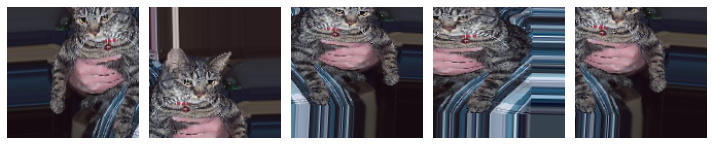

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [13]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [14]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


Validation 데이터를 확인해 봅시다. 크게 이미지와 정답 데이터로 구성이 되어 있습니다.

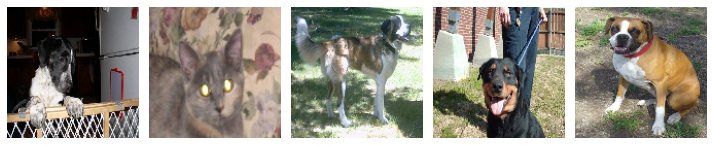

In [15]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [16]:
_[:5] # 정답 데이터

array([1., 0., 1., 1., 1.], dtype=float32)

## 1-1. VGG16 모델 구현하기
이제 VGG16 모델을 구현해 볼 시간입니다. VGG16 모델의 구조를 다시 상기해 보고, 코드로 직접 구현해 보세요.

참고: 예시 코드는 아래에 제공되어 있지만 예시 코드는 위에서 제공한 이미지의 VGG16 모델을 그대로 구현한 것이 아닙니다. 예시 코드를 참고하여 VGG16 모델을 구현해 보세요.


In [33]:
# 모델
input_layer=tf.keras.layers.Input(shape=(128, 128, 3))
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D((2, 2))(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024, activation='relu')(x)
x=tf.keras.layers.Dense(512, activation='relu')(x)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 128)       1475

softmax는 다중분류 모델이다. sigmoid로 단일분류를 해야한다.

손실함수, optimizer, metric을 설정해 줍니다.

손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다. 자유롭게 바꿔보세요.

In [36]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

모델 학습을 시켜봅시다.
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정합니다.

In [37]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/40
27/27 [==============================] - 15s 509ms/step - loss: 1.7388 - binary_accuracy: 0.5355 - val_loss: 0.7398 - val_binary_accuracy: 0.4700
Epoch 2/40
27/27 [==============================] - 14s 506ms/step - loss: 0.7891 - binary_accuracy: 0.5255 - val_loss: 0.6829 - val_binary_accuracy: 0.5780
Epoch 3/40
27/27 [==============================] - 14s 497ms/step - loss: 0.7698 - binary_accuracy: 0.5465 - val_loss: 0.6851 - val_binary_accuracy: 0.5810
Epoch 4/40
27/27 [==============================] - 14s 502ms/step - loss: 0.7185 - binary_accuracy: 0.5460 - val_loss: 0.7203 - val_binary_accuracy: 0.5000
Epoch 5/40
27/27 [==============================] - 14s 506ms/step - loss: 0.7286 - binary_accuracy: 0.5450 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 6/40
27/27 [==============================] - 14s 497ms/step - loss: 0.7311 - binary_accuracy: 0.5385 - val_loss: 0.6928 - val_binary_accuracy: 0.5000
Epoch 7/40
27/27 [==============================] - 14s 50

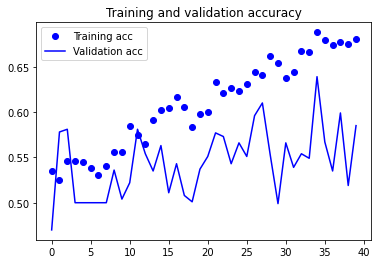

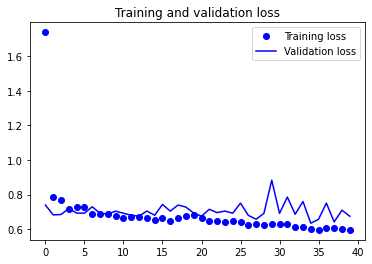

In [38]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
hyperparameter 변경, 모델 수정, optimizer 변경, skip connection, pre-trained model 등 다양한 방법을 사용하면 모델의 성능을 50% 이상으로 높일 수 있습니다. 다양한 실험을 통해 성능을 올려 보세요.

In [39]:
# 모델
input_layer=tf.keras.layers.Input(shape=(128, 128, 3))
x1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.BatchNormalization()(x1)
x1=tf.keras.layers.MaxPool2D((2, 2))(x1)

x1=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.BatchNormalization()(x1)
x1=tf.keras.layers.MaxPool2D((2, 2))(x1)

x1=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.BatchNormalization()(x1)
x1=tf.keras.layers.MaxPool2D((2, 2))(x1)

x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.BatchNormalization()(x1)
x1=tf.keras.layers.MaxPool2D((2, 2))(x1)

x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x1)
x1=tf.keras.layers.BatchNormalization()(x1)
x1=tf.keras.layers.MaxPool2D((2, 2))(x1)

x1=tf.keras.layers.Flatten()(x1)
x1=tf.keras.layers.Dense(1024, activation='relu')(x1)
x1=tf.keras.layers.Dense(512, activation='relu')(x1)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x1)

model1 = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model1.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 128)       1475

In [40]:
# hyperparameter 설정
# [[YOUR CODE]]
batch_size = 128
epochs = 100
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [41]:
# loss function, optimizer, metric 설정 및 모델 컴파일
# [[YOUR CODE]]
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model1.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [42]:
# 모델 학습
history = model1.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/100
15/15 [==============================] - 11s 601ms/step - loss: 2.2845 - binary_accuracy: 0.5220 - val_loss: 77.7726 - val_binary_accuracy: 0.5000
Epoch 2/100
15/15 [==============================] - 9s 595ms/step - loss: 1.1128 - binary_accuracy: 0.5104 - val_loss: 0.7194 - val_binary_accuracy: 0.4570
Epoch 3/100
15/15 [==============================] - 9s 586ms/step - loss: 0.9875 - binary_accuracy: 0.4824 - val_loss: 0.7003 - val_binary_accuracy: 0.5160
Epoch 4/100
15/15 [==============================] - 9s 589ms/step - loss: 0.8194 - binary_accuracy: 0.5226 - val_loss: 0.8244 - val_binary_accuracy: 0.5460
Epoch 5/100
15/15 [==============================] - 9s 580ms/step - loss: 0.7486 - binary_accuracy: 0.5150 - val_loss: 0.7047 - val_binary_accuracy: 0.5000
Epoch 6/100
15/15 [==============================] - 9s 602ms/step - loss: 0.7940 - binary_accuracy: 0.5106 - val_loss: 0.6942 - val_binary_accuracy: 0.4970
Epoch 7/100
15/15 [==============================] - 9s 

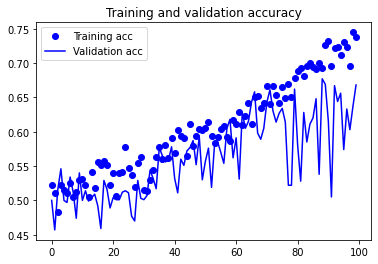

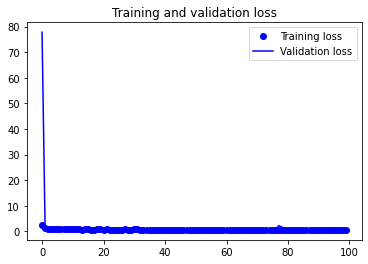

In [43]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 그래프 상으로는 아랫꺼가 더 안정적인 모델같아 보인다.

# 회고

* softmax 와 sigmoid 의 차이점을 알았다. 이 둘의 차이점은 sigmoid는 단일 모델에 대한 분류를 표현할때, 마지막에 넣는 활성화 함수고, softmax는 다중 분류 모델에 넣는 함수이다.

* 여러가지 실험중, val_binary_accuracy 가 늘어나지않거나 줄어들지 않아서, 애를 먹었다. 그 이유를 찾아보니, 오히려 generate를 한번더 해서 그런 것 같았다. 그래서, 빼고 해보니 정확도가 줄어들거나 늘어났다.

* 배치 사이즈를 높일수록 좀더 빠른 검사 시간이 나왔다. 배치 사이즈를 낮출수록 오히려 더 많은 시간이 걸렸다.

* 옵티마이저 아담외에는 유의미한값이 없다고 알려주셨다.

* VGG16 모델은 16개의 레이어로, flatten 레이어도 포함된다고 알게 되었다.

* 학습률 0.001이 더 좋은 효과를 나타냈다.


''' 역시 좀더 공부가필요했다. '''